## WIFI FP research
This page will be dedicated to small things we need to research regarding the WIFI FP algorithm.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import similarity as sm
import radiomap as rm
import wifi_fp as fp

from scipy.stats import rayleigh

In [2]:
# read data from data files
training_data    = pd.read_csv("sample_data/TrainingData.csv")
validation_data  = pd.read_csv("sample_data/ValidationData.csv")
wap_column_names = training_data.filter(regex=("WAP\d*")).columns
training_data    = training_data.drop(columns=["RELATIVEPOSITION", "USERID", "SPACEID"])

## RSSI distribution per device, per AP
We should create a histogram for each device and see the behavior. We should expect a rayleigh/rice distribution like behavior

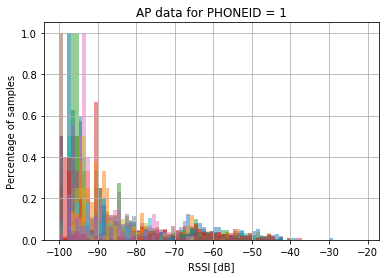

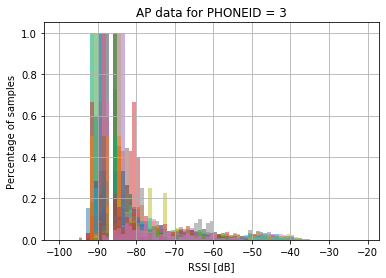

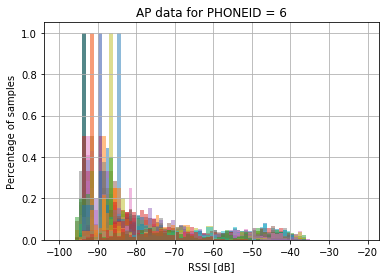

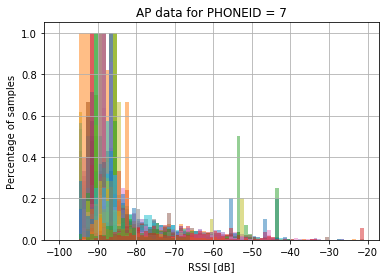

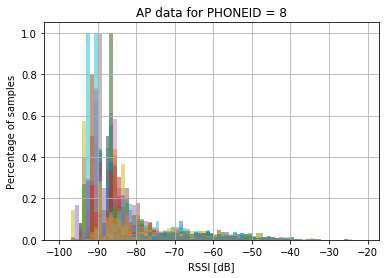

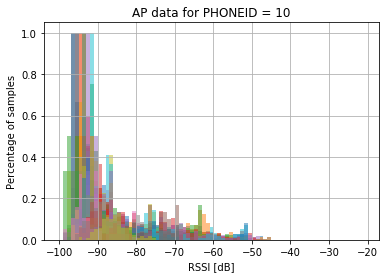

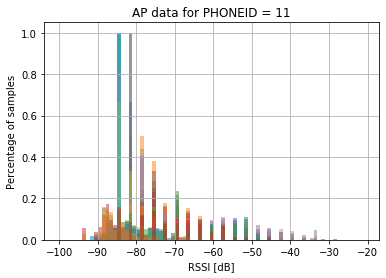

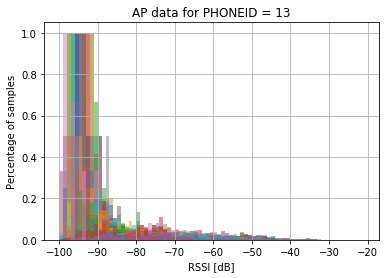

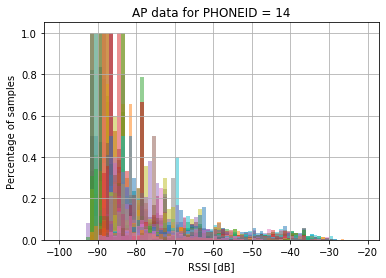

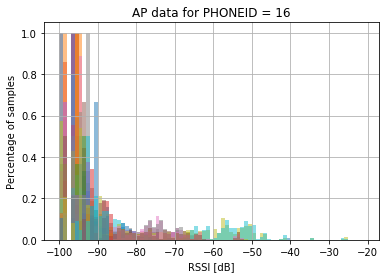

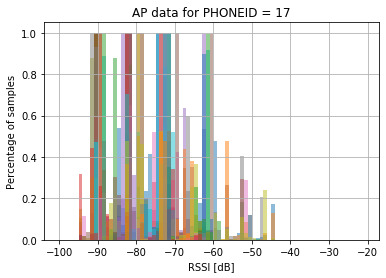

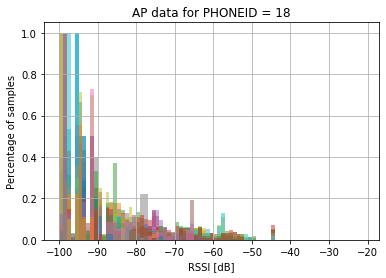

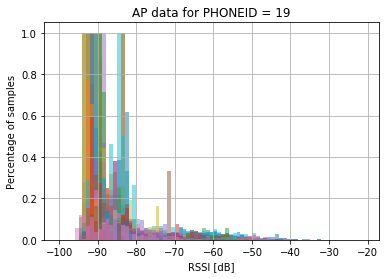

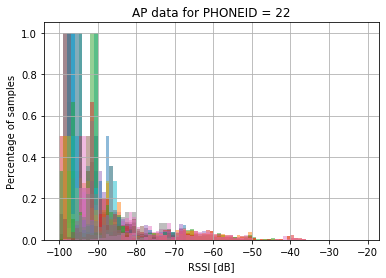

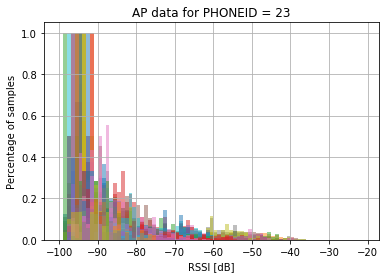

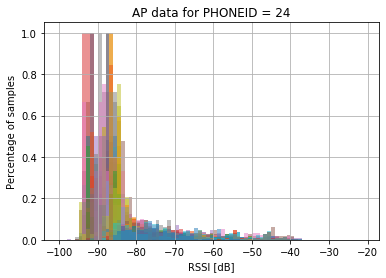

In [61]:
training_data_grp = training_data.groupby(["PHONEID"])
bin_range = np.arange(-100, -20, 1)
for grp in training_data_grp.groups.keys():
    td_grp = training_data_grp.get_group(grp)
    td_grp = td_grp.mask(td_grp[wap_column_names] == 100, np.nan)
    flds = wap_column_names[(~np.isnan(td_grp)).any(axis=0)[wap_column_names]]
    
    plt.figure()
    [plt.hist(td_grp[fld].to_list(), bin_range, alpha=0.5, label=fld, density=True) for fld in flds]
    plt.title("AP data for PHONEID = " + str(grp))
    plt.xlabel("RSSI [dB]")
    plt.ylabel("Percentage of samples")
    plt.grid()
    plt.show()

If we assume every phone's RSSI values for all APs behave like rayleigh distribution (which is quite hard to prove, but doesn't seem far off, and a better assumption than the standard gaussian assumption) we can attempt to normalize it.
The expected PDF is
$$f(x;\sigma )={\frac {x}{\sigma ^{2}}}e^{-x^{2}/(2\sigma ^{2})},\quad x\geq 0$$
But we might find it easier to work with the expected CDF,
$$F(x;\sigma )=1-e^{-x^{2}/(2\sigma ^{2})},\quad x\geq0$$
The ML estimator of $\sigma^{2}$ is known to be
$$\hat{\sigma}_{ML}^{2} = \frac{1}{2N}\sum_{i=1}^{N}{x^{2}_{i}}$$
Note that here of "x=0" is actually "x=-100" so we shall first normalize the measurements before estimating.
So let's check how well the data actually fit this CDF

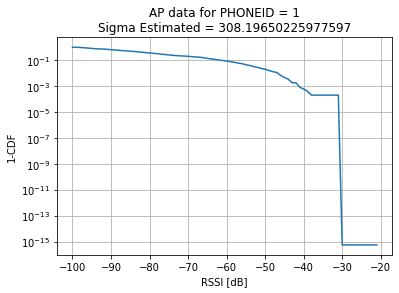

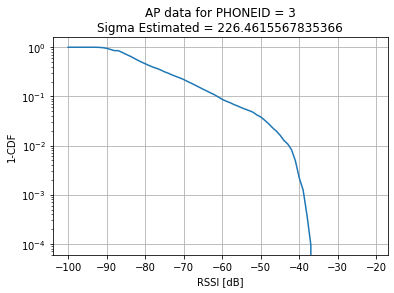

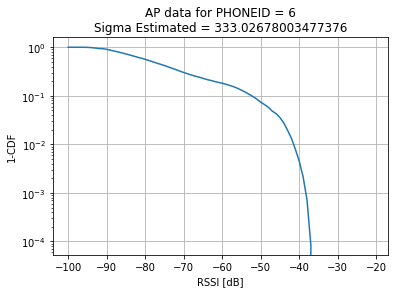

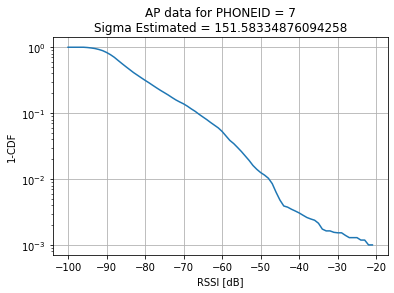

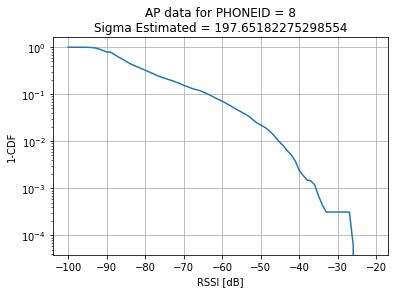

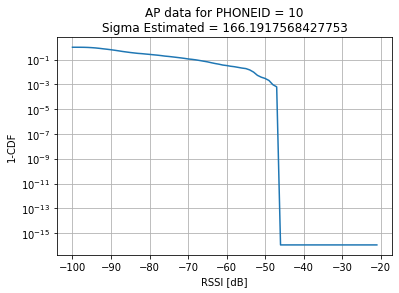

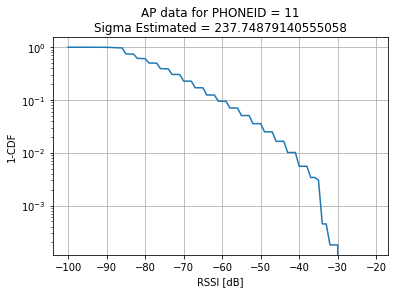

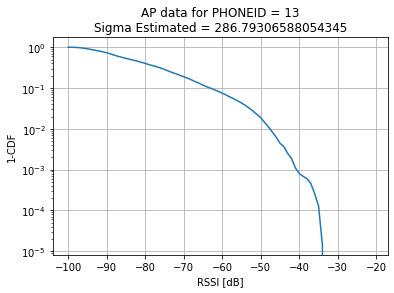

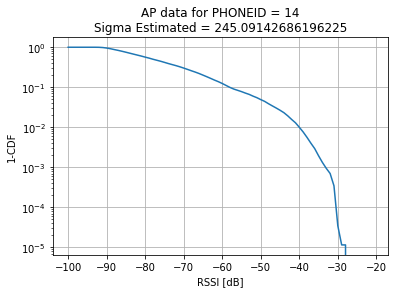

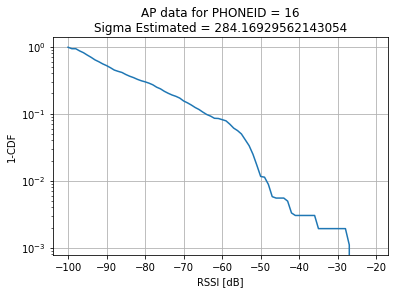

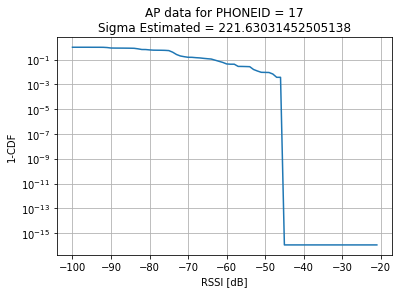

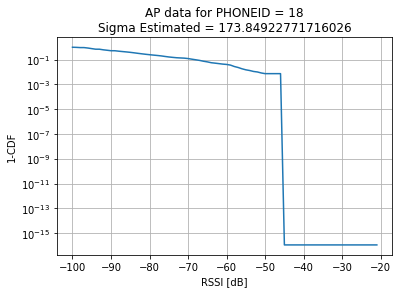

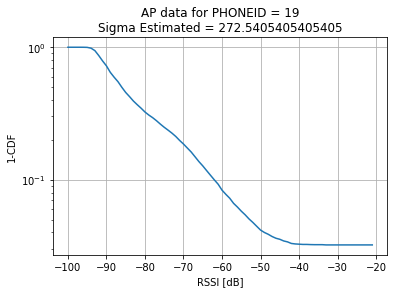

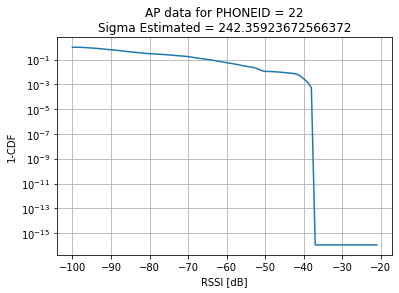

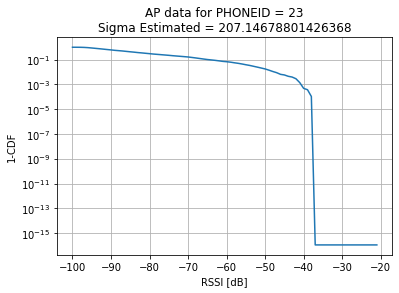

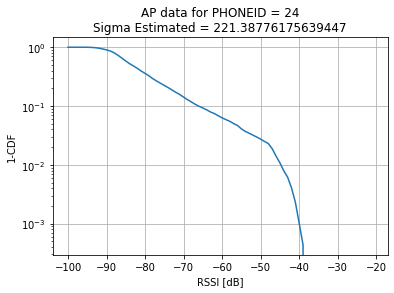

In [3]:
training_data_grp = training_data.groupby(["PHONEID"])
dx = 1
bin_range = np.arange(-100, -20, dx)
data_nrm, data_no_nrm = {}, {}
for grp in training_data_grp.groups.keys():
    td_grp = training_data_grp.get_group(grp)
    td_grp = td_grp.mask(td_grp[wap_column_names] == 100, np.nan)
    flds = wap_column_names[(~np.isnan(td_grp)).any(axis=0)[wap_column_names]]
    
    cnct_td = np.hstack([td_grp[fld].to_numpy() for fld in flds])
    hist_c, _ = np.histogram(cnct_td[~np.isnan(cnct_td)], bins = np.concatenate([bin_range, [np.Inf]]), density=True)
    cdf = np.cumsum(hist_c) * dx
    
    min_rssi = np.min(cnct_td[~np.isnan(cnct_td)])
    sigma_est = np.mean((cnct_td[~np.isnan(cnct_td)]-min_rssi)**2) / 2
    data_nrm[grp] = (cnct_td[~np.isnan(cnct_td)]-min_rssi)/np.sqrt(sigma_est)
    data_no_nrm[grp] = cnct_td[~np.isnan(cnct_td)]
    
    plt.figure()
    plt.plot(bin_range, 1-cdf)
    plt.yscale("log")
    plt.title("AP data for PHONEID = " + str(grp) + "\nSigma Estimated = " + str(sigma_est))
    plt.xlabel("RSSI [dB]")
    plt.ylabel("1-CDF")
    plt.grid()
    plt.show()

Some of the plots do look linear under the log scale, which indices a good fit for the rayleigh distribution, but some are pretty far off.

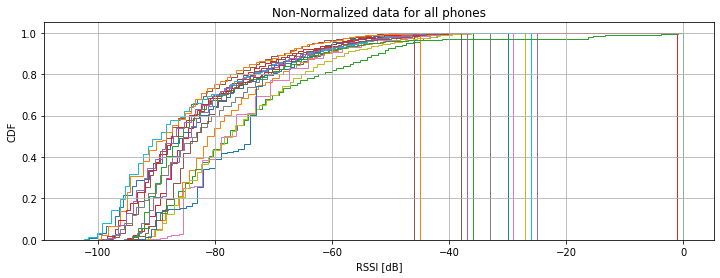

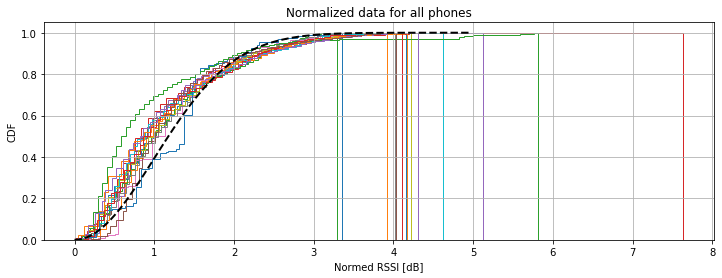

In [15]:
plt.figure(figsize=(12,4))
for gg in data_nrm:
    plt.hist(data_no_nrm[gg], 100, density=True, histtype='step', cumulative=True, label=str(gg))
plt.title("Non-Normalized data for all phones")
plt.xlabel("RSSI [dB]")
plt.ylabel("CDF")
plt.grid()
plt.show()


plt.figure(figsize=(12,4))
for gg in data_nrm:
    plt.hist(data_nrm[gg], 100, density=True, histtype='step', cumulative=True, label=str(gg))
x = np.arange(0,5, 0.05)
plt.plot(x,rayleigh.cdf(x), color="black", linestyle='dashed', linewidth=2)
plt.title("Normalized data for all phones")
plt.xlabel("Normed RSSI [dB]")
plt.ylabel("CDF")
plt.grid()
plt.show()
